# Пишем свою нейросеть

## Реализуем класс нейрона

In [1]:
#Построение нейрона

import numpy as np

#Функция активации
def f_active(x):
  return 1 / (1 + np.exp(-x))

class Neuron:
  def __init__(self, weights, bias):
    self.weights = weights
    self.bias = bias

  def evaluate(self, inputs):
    return f_active(np.dot(self.weights, inputs) + self.bias)

In [3]:
n = Neuron(np.array([0.4, 1]), 5) 
n.evaluate(np.array([11, 13]))   

0.9999999998130165

In [5]:
#Проверяем

y = 0.4*11+1*13+5
f_active(y)

0.9999999998130165

## Соединяем нейроны в простую полносвязную сеть

Для простоты возьмем всего два нейрона.

![image](ris1.jpeg)

In [53]:
#Строим структуру нейронной сети

class NeuralNetwork:
  '''
  Нейронная сеть с:
    - 2 входами
    - скрытым слоем с 2 нейронами (h1, h2)
    - выходным слоем с 1 нейроном (o1)
  Все нейроны имеют одинаковые веса и пороги:
    - w = [0.3, 0.7]
    - b = 0.5
  '''
  def __init__(self):
    weights = np.array([0.3, 0.7])
    bias = 0.5

    # Используем класс Neuron
    self.h1 = Neuron(weights, bias)
    self.h2 = Neuron(weights, bias)
    self.o1 = Neuron(weights, bias)

  def work(self, x):
    out_h1 = self.h1.evaluate(x)
    out_h2 = self.h2.evaluate(x)

    # Входы для o1 - это выходы h1 и h2
    out_o1 = self.o1.evaluate(np.array([out_h1, out_h2]))

    return out_o1

In [9]:
#Запускаем нейронную сеть

network = NeuralNetwork()
x = np.array([1, 2])
network.work(x)

0.8022234791817827

In [11]:
# Проверяем работу нейронной сети

out_h1 = f_active(0.3*1+0.7*2+0.5)
out_h2 = f_active(0.3*1+0.7*2+0.5)

out = f_active(0.3*out_h1+0.7*out_h2+0.5)
out

0.8022234791817827

## Обучение нейронной сети

Для того, чтобы начать обучать нейронную сеть, нужно научить ее различать, когда она получила хорошее решение, а когда плохое.

Для этого проще всего использовать так называемую функцию потерь loss. В качестве такой функции часто используют среднюю квадратическую ошибку (MSE - Mean squared error):

$$MSE = \frac{\sum_{i=1}^n (y^{predict}_i-y^{true}_i)^2}{n}$$

$y^{predict}_i$  - значение выхода нейронной сети для $i$-й входной точки,

$y^{true}_i$ - истинное значение на выходе для $i$-й входной точки.

In [20]:
# Реализуем функцию потерь

def mse_loss(y_true, y_pred):
  return ((y_true - y_pred) ** 2).mean()

На самом деле наша функция потерь завивит от весов и порогов всех входящих в нейронную сеть нейронов:

$$MSE = L(w_1,w_2,w_3,w_4,w_5,w_6,b_1,b_2,b_3)$$

Если мы хотим отрегулировать $w_1$, то должны вычислять частные производные по $w_1$:
$$\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial y^{predict}}\cdot \frac{\partial y^{predict}}{\partial w_1}=\frac{\sum_{i=1}^n 2(y^{predict}_i-y^{true}_i)}{n}\cdot \frac{\partial y^{predict}_i}{\partial w_1}$$

$$y^{predict}_i=f(w_5\cdot h_1+w_6\cdot h_2+b_3)$$

Производная по $w_1$ будет зависить только от $h_1$, поэтому:

$$\frac{\partial y^{predict}_i}{\partial w_1} = \frac{\partial y^{predict}_i}{\partial h_{1i}}\cdot \frac{\partial h_{1i}}{\partial w_1}$$

В свою очередь $h_1 = f(w_1\cdot x_1+w_2\cdot x_2+b_1)$, 
$$\frac{\partial h_{1i}}{\partial w_1} = \frac{\partial f(w_1\cdot x_1+w_2\cdot x_2+b_1)}{\partial w_1}$$

Здесь $f(x)=\frac{1}{1+e^{-x}}$ - выбранная функция активации,
$$f'(x) = \frac{e^{-x}}{(1+e^{-x})^2}=f(x)\cdot (1-f(x))$$

[Wolfram](https://www.wolframalpha.com/input?i=diff%281%2F%281%2Bexp%28-x%29%29%2Cx%29)

Таким образом, вычисление производной разбивается на части:

$$\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial y^{predict}}\cdot \frac{\partial y^{predict}}{\partial h_{1}}\cdot \frac{\partial h_1}{\partial w_1}$$
Такое постепенное вычисление от конца вначало получило название **обратного распространения ошибки** (backpropagation).

Попробуем научить нашу нейронную сеть вычислять функцию $y = \sqrt{x_1+1}+x_2$.

In [74]:
import pandas as pd
x1 = np.array([1,2,3,4,5,6,7,8,9,10])
x2 = np.array([1,2,3,4,5,6,7,8,9,10])
y = np.sqrt(x1+1)+x2

D = pd.DataFrame({'x1' : x1, 'x2': x2, 'y' : y})
D

,x1,x2,y
0,1,1,2.414214
1,2,2,3.732051
2,3,3,5.000000
3,4,4,6.236068
4,5,5,7.449490
5,6,6,8.645751
6,7,7,9.828427
7,8,8,11.000000
8,9,9,12.162278
9,10,10,13.316625


Пробуем вычислять значение функции на векторе $[1,1]$.

In [28]:
network.work(np.array([1,1]))

0.7887778795153473

Сеть выдает значение 0.7887778795153473, истинное значение равно 2.414214.

Выполним расчет $\frac{\partial L}{\partial w_1}$:

$$\frac{\partial L}{\partial y^{predict}} = 2(y^{predict}-y^{true})=2\cdot (0.7887778795153473-2.414214)=-3.250872240969305$$


$$\frac{\partial y^{predict}}{\partial h_{1}}=w_5\cdot f'(w_5h_1+w_6h_2+b_3)=0.3\cdot f'(0.3\cdot 0.8175744761936437+0.7\cdot 0.8175744761936437+0.5)$$
$$=0.3\cdot f'(1.3175744761936437)=0.3\cdot f(1.3175744761936437)\cdot (1-f(1.3175744761936437))=0.04998220089078587$$

$$\frac{\partial h_1}{\partial w_1} = x_1\cdot f'(w_1x_1+w_2x_2+b_1)=1\cdot f'(0.3\cdot 1+0.7\cdot 1+0.5)$$
$$=1\cdot f(1.5)\cdot(1-f(1.5)=0.14914645207033286$$

$$\frac{\partial L}{\partial w_1}=-3.250872240969305\cdot 0.04998220089078587\cdot 0.14914645207033286=-0.024234173037744566$$

Отрицаельное значение говорит о том, что увеличение $w_1$ позволит чуть уменьшить ошибку. Проверим это.

In [34]:
h1 = f_active(0.3*1+0.7*1+0.5)
h2 = f_active(0.3*1+0.7*1+0.5)
print(h1,h2)
0.3*f_active(1.3175744761936437)*(1-f_active(1.3175744761936437))

0.8175744761936437 0.8175744761936437


0.04998220089078587

In [37]:
f_active(1.5)*(1-f_active(1.5))

0.14914645207033286

In [39]:
-3.250872240969305* 0.04998220089078587* 0.14914645207033286

-0.024234173037744566

In [65]:
class NeuralNetwork_1:
  '''
  Нейронная сеть с:
    - 2 входами
    - скрытым слоем с 2 нейронами (h1, h2)
    - выходным слоем с 1 нейроном (o1)
  Все нейроны имеют одинаковые веса и пороги:
    - w = [0.3, 0.7]
    - b = 0.5
  '''
  def __init__(self):
    weights = np.array([0.3, 0.7])
    bias = 0.5

    # Используем класс Neuron
    self.h1 = Neuron(np.array([0.4,0.7]), bias)
    self.h2 = Neuron(weights, bias)
    self.o1 = Neuron(weights, bias)

  def work(self, x):
    out_h1 = self.h1.evaluate(x)
    out_h2 = self.h2.evaluate(x)

    # Входы для o1 - это выходы h1 и h2
    out_o1 = self.o1.evaluate(np.array([out_h1, out_h2]))

    return out_o1

In [66]:
network = NeuralNetwork()
x = np.array([1, 1])
network.work(x)

0.7887778795153473

In [67]:
mse_loss(np.array([2.414214]), np.array([0.7887778795153473]))

2.642042581776198

In [68]:
network1 = NeuralNetwork_1()
x = np.array([1, 1])
network1.work(x)

0.7894989144967673

In [69]:
mse_loss(np.array([2.414214]), np.array([0.7894989144967673]))

2.6396991090617763

Но у нас минимизация получилась только на одной точке данных. Для оптимизации на всех исходных данных используем стохастический градиентный спуск (stochastic gradient descent). Суть метода состоит в том, чтобы обновлять веса по формуле:
$$w_1=w_1-\eta\cdot \frac{\partial L}{\partial w_1}$$

$\eta$ - константа, называемая скоростью обучения, которая определяет, как быстро наша сеть учится.

Если мы сделаем то же самое для каждого веса и порога в сети, потери будут постепенно уменьшаться, и наша сеть будет выдавать более точные результаты.

Процесс обучения сети будет выглядеть примерно так:

1. Выбираем одно наблюдение из набора данных. Именно то, что мы работаем только с одним наблюдением, делает наш градиентный спуск стохастическим.
2. Считаем все частные производные функции потерь по всем весам и порогам ($\frac{\partial L}{\partial w_1}, \frac{\partial L}{\partial w_2}, \frac{\partial L}{\partial b_1}, \ldots$)
3. Используем формулу обновления, чтобы обновить значения каждого веса и порога.
4. Снова переходим к шагу 1.

Приступим к реализации.  Поскольку у нас простая сеть, было вы самонадеянно считать, что она сразу может решать сложные задачи. 
Попробуем решить задачу исключающего или:

In [107]:
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def deriv_sigmoid(x):
  # Производная сигмоиды: f'(x) = f(x) * (1 - f(x))
  fx = sigmoid(x)
  return fx * (1 - fx)

def mse_loss(y_true, y_pred):
  # y_true и y_pred - массивы numpy одинаковой длины.
  return ((y_true - y_pred) ** 2).mean()

class OurNeuralNetwork:
  '''
  Нейронная сеть с:
    - 2 входами
    - скрытым слоем с 2 нейронами (h1, h2)
    - выходной слой с 1 нейроном (o1)
  '''
  def __init__(self):
    # Веса
    self.w1 = np.random.normal()
    self.w2 = np.random.normal()
    self.w3 = np.random.normal()
    self.w4 = np.random.normal()
    self.w5 = np.random.normal()
    self.w6 = np.random.normal()

    # Пороги
    self.b1 = np.random.normal()
    self.b2 = np.random.normal()
    self.b3 = np.random.normal()

  def feedforward(self, x):
    # x is a numpy array with 2 elements.
    h1 = sigmoid(self.w1 * x[0] + self.w2 * x[1] + self.b1)
    h2 = sigmoid(self.w3 * x[0] + self.w4 * x[1] + self.b2)
    o1 = sigmoid(self.w5 * h1 + self.w6 * h2 + self.b3)
    return o1

  def train(self, data, all_y_trues):
    '''
    - data - массив numpy (n x 2) numpy, n = к-во наблюдений в наборе. 
    - all_y_trues - массив numpy с n элементами.
      Элементы all_y_trues соответствуют наблюдениям в data.
    '''
    learn_rate = 0.1
    epochs = 10000 # сколько раз пройти по всему набору данных 

    for epoch in range(epochs):
      for x, y_true in zip(data, all_y_trues):
        # --- Прямой проход (эти значения нам понадобятся позже)
        sum_h1 = self.w1 * x[0] + self.w2 * x[1] + self.b1
        h1 = sigmoid(sum_h1)

        sum_h2 = self.w3 * x[0] + self.w4 * x[1] + self.b2
        h2 = sigmoid(sum_h2)

        sum_o1 = self.w5 * h1 + self.w6 * h2 + self.b3
        o1 = sigmoid(sum_o1)
        y_pred = o1

        # --- Считаем частные производные.
        # --- Имена: d_L_d_w1 = "частная производная L по w1"
        d_L_d_ypred = -2 * (y_true - y_pred)

        # Нейрон o1
        d_ypred_d_w5 = h1 * deriv_sigmoid(sum_o1)
        d_ypred_d_w6 = h2 * deriv_sigmoid(sum_o1)
        d_ypred_d_b3 = deriv_sigmoid(sum_o1)

        d_ypred_d_h1 = self.w5 * deriv_sigmoid(sum_o1)
        d_ypred_d_h2 = self.w6 * deriv_sigmoid(sum_o1)

        # Нейрон h1
        d_h1_d_w1 = x[0] * deriv_sigmoid(sum_h1)
        d_h1_d_w2 = x[1] * deriv_sigmoid(sum_h1)
        d_h1_d_b1 = deriv_sigmoid(sum_h1)

        # Нейрон h2
        d_h2_d_w3 = x[0] * deriv_sigmoid(sum_h2)
        d_h2_d_w4 = x[1] * deriv_sigmoid(sum_h2)
        d_h2_d_b2 = deriv_sigmoid(sum_h2)

        # --- Обновляем веса и пороги
        # Нейрон h1
        self.w1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_w1
        self.w2 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_w2
        self.b1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_b1

        # Нейрон h2
        self.w3 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_w3
        self.w4 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_w4
        self.b2 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_b2

        # Нейрон o1
        self.w5 -= learn_rate * d_L_d_ypred * d_ypred_d_w5
        self.w6 -= learn_rate * d_L_d_ypred * d_ypred_d_w6
        self.b3 -= learn_rate * d_L_d_ypred * d_ypred_d_b3

      # --- Считаем полные потери в конце каждой эпохи
      if epoch % 100 == 0:
        y_preds = np.apply_along_axis(self.feedforward, 1, data)
        loss = mse_loss(all_y_trues, y_preds)
        print("Epoch %d loss: %.3f" % (epoch, loss))

In [108]:
# Определим набор данных
data = np.array([[0,0],[0,1],[1,0],[1,1]])
all_y_trues = np.array([0,1,1,0])

In [109]:
network = OurNeuralNetwork()
network.train(data, all_y_trues)

Epoch 0 loss: 0.255
Epoch 100 loss: 0.221
Epoch 200 loss: 0.209
Epoch 300 loss: 0.200
Epoch 400 loss: 0.190
Epoch 500 loss: 0.181
Epoch 600 loss: 0.170
Epoch 700 loss: 0.159
Epoch 800 loss: 0.144
Epoch 900 loss: 0.124
Epoch 1000 loss: 0.101
Epoch 1100 loss: 0.078
Epoch 1200 loss: 0.059
Epoch 1300 loss: 0.045
Epoch 1400 loss: 0.035
Epoch 1500 loss: 0.028
Epoch 1600 loss: 0.023
Epoch 1700 loss: 0.019
Epoch 1800 loss: 0.016
Epoch 1900 loss: 0.014
Epoch 2000 loss: 0.012
Epoch 2100 loss: 0.011
Epoch 2200 loss: 0.010
Epoch 2300 loss: 0.009
Epoch 2400 loss: 0.008
Epoch 2500 loss: 0.007
Epoch 2600 loss: 0.007
Epoch 2700 loss: 0.006
Epoch 2800 loss: 0.006
Epoch 2900 loss: 0.005
Epoch 3000 loss: 0.005
Epoch 3100 loss: 0.005
Epoch 3200 loss: 0.004
Epoch 3300 loss: 0.004
Epoch 3400 loss: 0.004
Epoch 3500 loss: 0.004
Epoch 3600 loss: 0.004
Epoch 3700 loss: 0.003
Epoch 3800 loss: 0.003
Epoch 3900 loss: 0.003
Epoch 4000 loss: 0.003
Epoch 4100 loss: 0.003
Epoch 4200 loss: 0.003
Epoch 4300 loss: 0.003


In [113]:
#Смотрим работу
network.feedforward(np.array([0,1]))

0.9722806238304387

Можно использовать различные датасеты.

In [90]:
!pip3 install datasets

/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.13.1-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 510 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 38.5 MB 419 kB/s eta 0:00:01
     |████████████████████████████████| 116 kB 554 kB/s eta 0:00:01
     |████████████████████████████████| 194 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 5.1 MB/s eta 0:00:01
     |██████████████████████████████

In [91]:
import pydataset as ds

In [93]:
G=ds.data('HairEyeColor')
display(G)

,Hair,Eye,Sex,Freq
1,Black,Brown,Male,32
2,Brown,Brown,Male,53
3,Red,Brown,Male,10
4,Blond,Brown,Male,3
5,Black,Blue,Male,11
6,Brown,Blue,Male,50
7,Red,Blue,Male,10
8,Blond,Blue,Male,30
9,Black,Hazel,Male,10
10,Brown,Hazel,Male,25


# Пробуем работать с нейронками

In [1]:
!pip install keras

/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.13.1-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 1.7 MB 1.3 MB/s eta 0:00:01


In [4]:
!pip install tensorflow

/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.13.1-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/juna/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 479.6 MB 23 kB/s s eta 0:00:01    |█████▍                          | 80.6 MB 25.4 MB/s eta 0:00:16     |████████                        | 120.4 MB 14.7 MB/s eta 0:00:25     |████████████▍                   | 186.5 MB 16.2 MB/s eta 0:00:19     |██████████████▎                 | 213.6 MB 14.1 MB/s eta 0:00:19     |███████████████▏       

In [29]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [23]:
import matplotlib.pyplot as plt

0


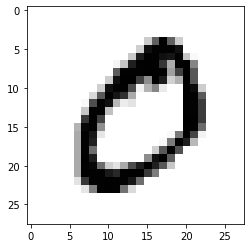

4


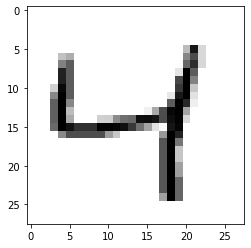

1


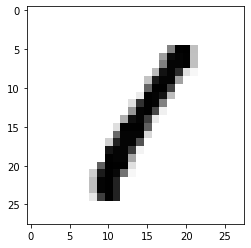

9


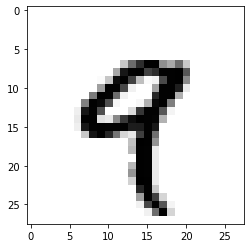

2


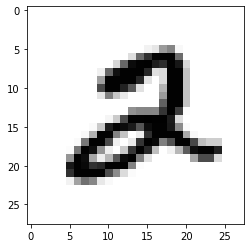

1


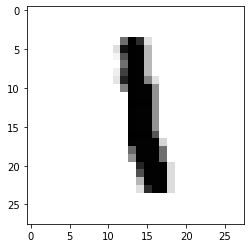

3


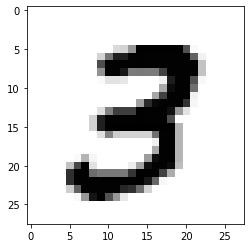

1


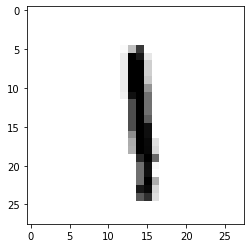

4


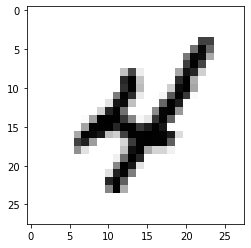

3


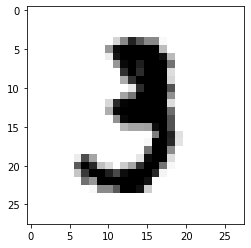

In [24]:
#Первые 10 изображений из обучающей выборки
for i in range(10):
    digit = train_images[i+1]
    print(train_labels[i+1])
    plt.imshow(digit, cmap = plt.cm.binary)
    plt.show()

In [30]:
#Конструируем сеть

from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape = (28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

Основным строительным блоком нейронных сетей является *слой* (или *уровень*), модуль обработки данных, который можно рассматривать как фильтр для данных.

Он принимает некоторые данные и выводит их в более полезной форме. В частности, слои извлекают *представления* из подаваемых в них данных, которые, кк мы надеемся, будут иметь больше смысла для решения задачи. Фактически методика глубокого обучения заключается в объединении простых слоев, реализующих некоторую форму поэтапной *очистки данных*. Модель глубокого обучения можно сравнить с ситом, состоящим из последовательности фильтров все более тонкой очистки данных - слоев.

В нашем случае сеть состоит из последовательности двух слоев Dense, которые являются *полносвязными* нейронными слоями. Второй (и последний) слой - это 10-переменный слой потерь (softmax layer), возвращающий массив с 10 оценками вероятностей (в сумме дающих 1). 

Каждая оценка определяет вероятность принадлежности текущего изображения к одному из 10 классов цифр.

Чтобы подготовить сеть к обучению, нужно настроить еще три параметра для этапа *компиляции*:

- *функция потерь*, которая определяет, как сеть должна оценивать качество своей работы на обучающих данных и, соответственно, как корректировать ее в правильном направлении;
- *оптимизатор* - механизм, с помощью которого сеть будет обновлять себя, опираясь на наблюдаемые данные и функцию потерь.
- *метрики для мониторинга на этапах обучения и тестирования* - здесь нас будет интересовать только точность (доля правильно классифицированных изображений).

In [31]:
network.compile(optimizer = 'rmsprop', 
                loss = 'categorical_crossentropy',
                metrics=['accuracy']) 

Выполним предварительную обработку данных.

In [32]:
train_images = train_images.reshape((60000,28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000,28 * 28))
test_images = test_images.astype('float32') / 255

In [33]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Теперь можно начинать обучение, для чего в Keras достаточно вызвать метод fit - он пытается *адаптировать* модель под обучающие данные.

In [34]:
network.fit(train_images,train_labels, epochs = 5, batch_size = 128)

Epoch 1/5


2024-02-21 09:43:19.943231: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


469/469 [==============================] - 7s 12ms/step - loss: 0.2673 - accuracy: 0.9232
Epoch 2/5
469/469 [==============================] - 6s 12ms/step - loss: 0.1080 - accuracy: 0.9686
Epoch 3/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0709 - accuracy: 0.9789
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0513 - accuracy: 0.9849
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0380 - accuracy: 0.9889


In [38]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

2024-02-21 09:47:55.771757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 2s 4ms/step - loss: 0.0704 - accuracy: 0.9781


In [39]:
print(test_loss)
print(test_acc)

0.07040389627218246
0.9781000018119812


In [41]:
ynew = network.predict(test_images)

2024-02-21 09:51:10.631287: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 4ms/step


In [43]:
ynew[0]

array([2.93029245e-07, 3.97084357e-08, 2.68561489e-05, 8.15597305e-05,
       1.12755236e-10, 2.16841727e-07, 1.89025410e-11, 9.99885619e-01,
       1.35423193e-07, 5.21740094e-06], dtype=float32)

In [44]:
test_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)